# Pipeline Regresión Logística para Clasificación
## Data Mining - Doctorado UDP 2025
**Bastián González-Bustamante** \
Octubre 2025

*Nota*. Están cargados los paquetes necesarios para NB, SVM, RF y XGBoost

In [1]:
## Importar librerías necesarias
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score, classification_report
)
import warnings

In [2]:
## Ignorar warnings para una salida más limpia
warnings.filterwarnings('ignore')

## Cargar el dataset (California Housing)
* En esta oportunidad fusionaremos ambos y luego seleccionaremos solo algunas variables para los modelos

In [3]:
# Cargar el dataset
california = fetch_california_housing()
X = pd.DataFrame(california.data, columns=california.feature_names)
y = pd.Series(california.target, name='MedHouseVal')  # Valor medio de las viviendas

# Combinar las características y el outcome en un solo DataFrame
X['MedHouseVal'] = y

## Explorando y limpiando los datos

In [4]:
# Inspección
print(X.head())

   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  MedHouseVal  
0    -122.23        4.526  
1    -122.22        3.585  
2    -122.24        3.521  
3    -122.25        3.413  
4    -122.25        3.422  


In [5]:
# Inspección
print(y.head())

0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: MedHouseVal, dtype: float64


In [6]:
## Data shape
X.shape

(20640, 9)

In [7]:
## Remover filas con valores faltantes en el outcome
data_clean = X.dropna(subset=['MedHouseVal'])

In [8]:
## Data shape
data_clean.shape

(20640, 9)

In [9]:
## Outcome shape
y.shape

(20640,)

## Selección de "features"
* **MedInc**. Median Income (Ingreso Mediano). Ingreso mediano de los hogares en la zona, expresado en decenas de miles de dólares. Es una medida de la situación económica de la región.
* **HouseAge**. Housing Age (Edad de las Casas). Edad promedio de las viviendas en la zona, medida en años. Proxy de desarrollo histórico de la comunidad.
* **AveRooms**. Average Rooms (Promedio de Habitaciones). Número promedio de habitaciones por hogar en la zona. Total de habitaciones sobre el total de viviendas.
* **Population**. Population (Población). Número total de personas que viven en la zona. Debería influir en la demanda de viviendas.
* **AveOccup**. Average Occupancy (Promedio de Ocupantes). Número promedio de ocupantes por hogar. Población total sobre el número total de viviendas.

In [10]:
selected_columns = ['MedInc', 'HouseAge', 'AveRooms', 'Population', 'AveOccup']
features = X[selected_columns]

## Cómo lidiar con los valores faltantes

In [11]:
X_isna = features.isna().any(axis=1)

features = features.drop(features[X_isna].index)
y = y.drop(y[X_isna].index)

## Preprocesamiento de datos

### Seleccionar automáticamente las columnas numéricas y categóricas

In [12]:
from sklearn.compose import make_column_selector as selector 

numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(features)
categorical_columns = categorical_columns_selector(features)

### Definir un preprocesador

In [13]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor = StandardScaler()

from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, categorical_columns),
    ('standard_scaler', numerical_preprocessor, numerical_columns)])

## División de los datos en entrenamiento y prueba

In [14]:
## División 70 / 30
X_train, X_test, y_train, y_test = train_test_split(
    features, y, test_size=0.30, random_state=86)

In [15]:
## Preparación para clasificación: Binarizar la variable
discretizer = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='quantile')
y_train_class = discretizer.fit_transform(y_train.values.reshape(-1, 1)).astype(int).flatten()
y_test_class = discretizer.transform(y_test.values.reshape(-1, 1)).astype(int).flatten()

## Pipeline para entrenar el modelo

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

model = make_pipeline(preprocessor, LogisticRegression(max_iter=500))
model

,steps,"[('columntransformer', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('one-hot-encoder', ...), ('standard_scaler', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [17]:
logistic = model.fit(X_train, y_train_class)

## Evaluar el modelo

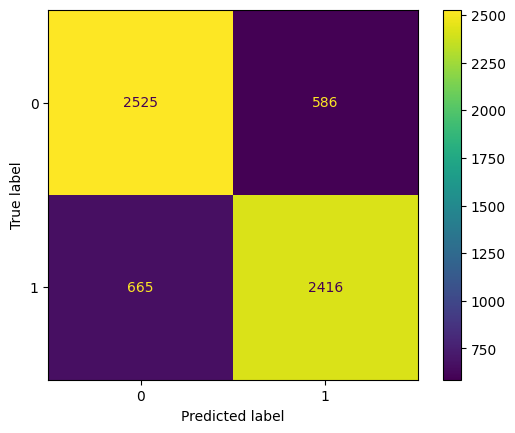

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay

logistic_matrix = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test_class)

In [19]:
## Función para imprimir métricas de clasificación
def print_classification_metrics(y_true, y_pred, model_name):
    print(f"--- {model_name} ---")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred, average='weighted'):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred, average='weighted'):.4f}")
    print(f"F1-Score: {f1_score(y_true, y_pred, average='weighted'):.4f}")
    print("Classification Report:")
    print(classification_report(y_true, y_pred))
    print("\n")

In [20]:
y_pred_logistic = logistic.predict(X_test)
print_classification_metrics(y_test_class, y_pred_logistic, "Modelo Logístico para Clasificación")

--- Modelo Logístico para Clasificación ---
Accuracy: 0.7980
Precision: 0.7981
Recall: 0.7980
F1-Score: 0.7979
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.81      0.80      3111
           1       0.80      0.78      0.79      3081

    accuracy                           0.80      6192
   macro avg       0.80      0.80      0.80      6192
weighted avg       0.80      0.80      0.80      6192



